tensor([3.], device='cuda:0')
tensor(-0.0355) tensor(1.1349)


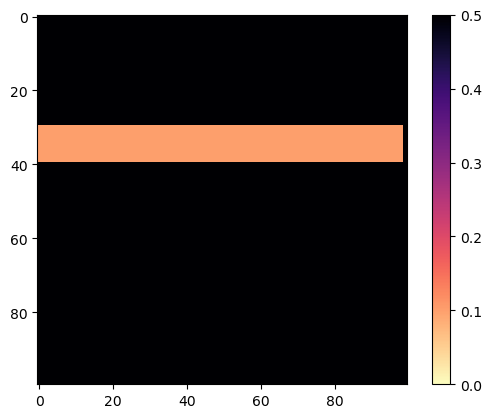

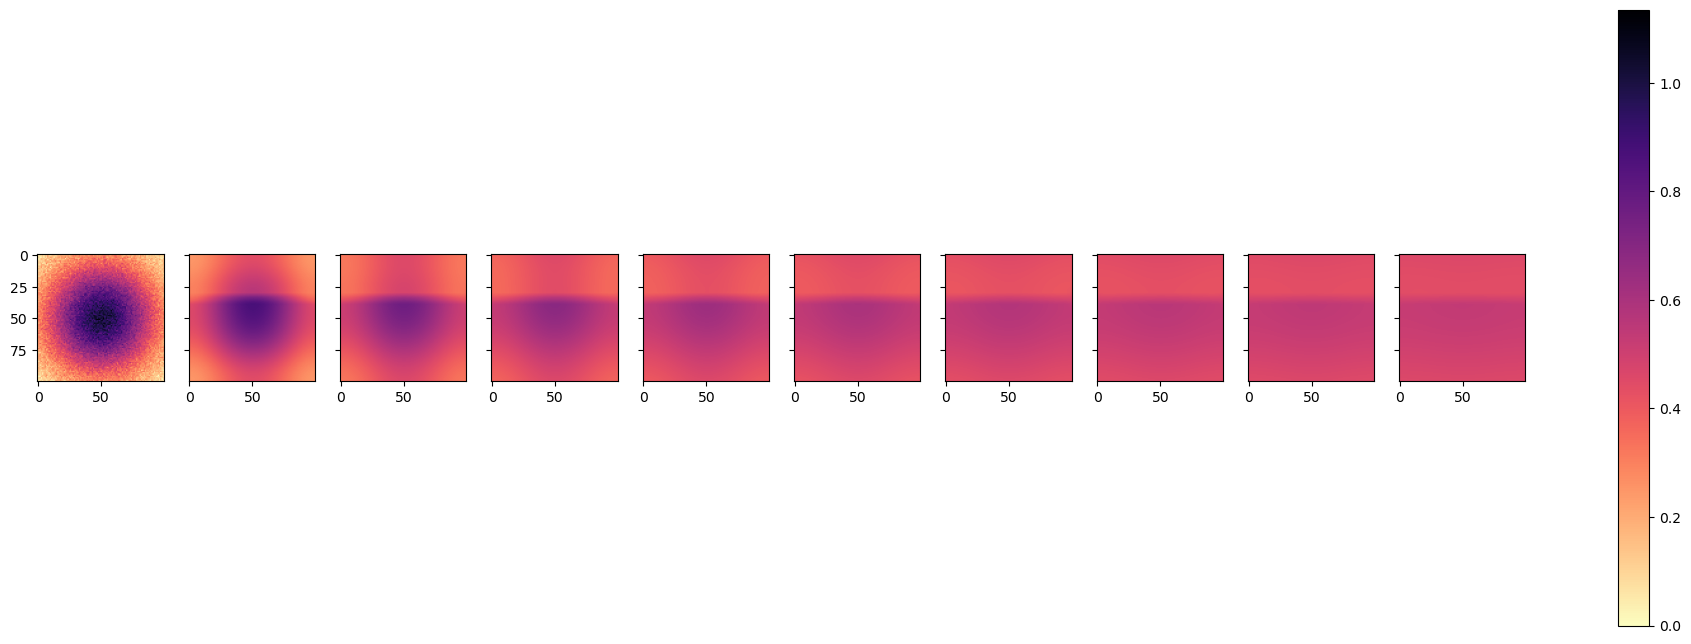

In [ ]:
import torch
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

a = torch.tensor([1.0], device="cuda")
b = torch.tensor([2.0], device="cuda")
c = a + b
print(c)

# Define the domain
nx, ny = 100, 100  # Number of grid points
dx, dy = 0.01, 0.01  # Grid spacing
dt = 0.00005  # Time step
nt = 5000  # Number of time steps

# Create the initial temperature field (e.g., a Gaussian bump)
x = torch.linspace(0, (nx-1)*dx, nx)
y = torch.linspace(0, (ny-1)*dy, ny)
X, Y = torch.meshgrid(x, y, indexing='ij')
T = torch.empty(nt, nx, ny)
noise_amplitude = 0.05  # adjust this value to control noise level
initial_condition = torch.exp(-((X-0.5)**2 + (Y-0.5)**2) / 0.2)
noise = noise_amplitude * torch.randn_like(initial_condition)
T[0, :, :] = initial_condition + noise
print(torch.min(T), torch.max(T))
# Define the heterogeneous diffusion coefficient
D = torch.ones_like(T[0, :, :]) * 0.5
D[30:40, 0:99] = 0.1 

fig, ax = plt.subplots()
img = ax.imshow(D, cmap="magma_r", vmin=0, vmax=0.5)
fig.colorbar(img)
fig.savefig("diffusion.png")

def gradient(T, dx, dy):
    """Gradient part of the PDE."""
    T_x = (torch.roll(T, shifts=-1, dims=0) - torch.roll(T, shifts=1, dims=0)) / (2 * dx)
    T_y = (torch.roll(T, shifts=-1, dims=1) - torch.roll(T, shifts=1, dims=1)) / (2 * dy)
    return T_x, T_y

def laplacian(T, dx, dy):
    """Laplacian part of the pde."""
    T_xx = (torch.roll(T, shifts=-1, dims=0) - 2 * T + torch.roll(T, shifts=1, dims=0)) / dx**2
    T_yy = (torch.roll(T, shifts=-1, dims=1) - 2 * T + torch.roll(T, shifts=1, dims=1)) / dy**2

    return T_xx + T_yy

def heat_equation_rhs(T, D, dx, dy):
    """Heat equation RHS."""
    T_x, T_y = gradient(T, dx, dy)
    D_x, D_y = gradient(D, dx, dy)
    
    diffusion_term = D * laplacian(T, dx, dy)
    gradient_term = D_x * T_x + D_y * T_y
    
    return diffusion_term + gradient_term

def rk4_step(T, D, dx, dy, dt):
    """RK4 time stepping scheme."""
    k1 = heat_equation_rhs(T, D, dx, dy)
    k2 = heat_equation_rhs(T + 0.5 * dt * k1, D, dx, dy)
    k3 = heat_equation_rhs(T + 0.5 * dt * k2, D, dx, dy)
    k4 = heat_equation_rhs(T + dt * k3, D, dx, dy)
    return T + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

# Time-stepping loop
for t in range(nt - 2):
    T[t + 1, :, :] = rk4_step(T[t, :, :], D, dx, dy, dt)

# show final temperature distribution
indices_step = nt // 10
n_plots = nt // indices_step
fig, axs = plt.subplots(ncols=n_plots, sharex=True, sharey=True, figsize=(24, 8))
vmax = torch.max(T)

# Plot each temperature distribution and capture the image object
for step in range(n_plots):
    im = axs[step].imshow(T[step * indices_step, :, :], vmin=0, vmax=vmax, cmap="magma_r")

# Create a common colorbar for all subplots
fig.colorbar(im, ax=axs.ravel().tolist(), orientation="vertical")

plt.show()

fig.savefig("results.png")
